<span style="color:orange; font-weight:bold">Note: To answer questions based on text documents, we recommend the procedure in <a href="https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb">Question Answering using Embeddings</a>. Some of the code below may rely on <a href="https://github.com/openai/openai-cookbook/tree/main/transition_guides_for_deprecated_API_endpoints">deprecated API endpoints</a>.</span>

# 1. Collect Wikipedia data about Olympic Games 2020

The idea of this project is to create a question answering model, based on a few paragraphs of provided text. Base GPT-3 models do a good job at answering questions when the answer is contained within the paragraph, however if the answer isn't contained, the base models tend to try their best to answer anyway, often leading to confabulated answers. 

To create a model which answers questions only if there is sufficient context for doing so, we first create a dataset of questions and answers based on paragraphs of text. In order to train the model to answer only when the answer is present, we also add adversarial examples, where the question doesn't match the context. In those cases, we ask the model to output "No sufficient context for answering the question". 

We will perform this task in three notebooks:
1. The first (this) notebook focuses on collecting recent data, which GPT-3 didn't see during it's pre-training. We picked the topic of Olympic Games 2020 (which actually took place in the summer of 2021), and downloaded 713 unique pages. We organized the dataset by individual sections, which will serve as context for asking and answering the questions.
2. The [second notebook](olympics-2-create-qa.ipynb) will utilize Davinci-instruct to ask a few questions based on a Wikipedia section, as well as answer those questions, based on that section.
3. The [third notebook](olympics-3-train-qa.ipynb) will utilize the dataset of context, question and answer pairs to additionally create adversarial questions and context pairs, where the question was not generated on that context. In those cases the model will be prompted to answer "No sufficient context for answering the question". We will also train a discriminator model, which predicts whether the question can be answered based on the context or not.

## 1.1 Data extraction using the wikipedia API
Extracting the data will take about half an hour, and processing will likely take about as much.

In [1]:
import pandas as pd
import wikipedia


def filter_olympic_2020_titles(titles):
    """
    Get the titles which are related to Olympic games hosted in 2020, given a list of titles
    """
    titles = [title for title in titles if '2020' in title and 'olympi' in title.lower()]
    
    return titles

def get_wiki_page(title):
    """
    Get the wikipedia page given a title
    """
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None

def recursively_find_all_pages(titles, titles_so_far=set()):
    """
    Recursively find all the pages that are linked to the Wikipedia titles in the list
    """
    all_pages = []
    
    titles = list(set(titles) - titles_so_far)
    titles = filter_olympic_2020_titles(titles)
    titles_so_far.update(titles)
    for title in titles:
        page = get_wiki_page(title)
        if page is None:
            continue
        all_pages.append(page)

        new_pages = recursively_find_all_pages(page.links, titles_so_far)
        for pg in new_pages:
            if pg.title not in [p.title for p in all_pages]:
                all_pages.append(pg)
        titles_so_far.update(page.links)
    return all_pages



In [7]:
p=get_wiki_page(["2020 Summer Olympics"])
filter_olympic_2020_titles(p.links)

["2020 AFC Women's Olympic Qualifying Tournament",
 '2020 Asia & Oceania Boxing Olympic Qualification Tournament',
 '2020 European Boxing Olympic Qualification Tournament',
 "2020 FIBA Women's Olympic Qualifying Tournaments – Belgrade 2",
 '2020 Olympics',
 '2020 Summer Olympic and Paralympic Games mascots',
 '2020 Summer Olympics',
 '2020 Summer Olympics Parade of Nations',
 '2020 Summer Olympics closing ceremony',
 '2020 Summer Olympics closing ceremony flag bearers',
 '2020 Summer Olympics development',
 '2020 Summer Olympics marketing',
 '2020 Summer Olympics medal table',
 '2020 Summer Olympics opening ceremony',
 '2020 Summer Olympics pictograms',
 '2020 Summer Olympics torch relay',
 '2020 Winter Youth Olympics',
 'Afghanistan at the 2020 Summer Olympics',
 'Albania at the 2020 Summer Olympics',
 'Algeria at the 2020 Summer Olympics',
 'American Samoa at the 2020 Summer Olympics',
 'Andorra at the 2020 Summer Olympics',
 'Angola at the 2020 Summer Olympics',
 'Antigua and Barbud

In [4]:
p.content

'The 2020 Summer Olympics (Japanese: 2020年夏季オリンピック, Hepburn: Nisen Nijū-nen Kaki Orinpikku), officially the Games of the XXXII Olympiad (第三十二回オリンピック競技大会, Dai Sanjūni-kai Orinpikku Kyōgi Taikai) and also known as Tokyo 2020 (東京2020, Tōkyō Nii Zero Nii Zero), was an international multi-sport event held from 23 July to 8 August 2021 in Tokyo, Japan, with some preliminary events that began on 21 July.\nTokyo was selected as the host city during the 125th IOC Session in Buenos Aires, Argentina, on 7 September 2013. The Games were originally scheduled to take place from 24 July to 9 August 2020, but due to the global COVID-19 pandemic, on 24 March 2020, the event was postponed to 2021, the first such instance in the history of the Olympic Games (previous games had been cancelled but not rescheduled). However, the event retained the Tokyo 2020 branding for marketing purpose. It was largely held behind closed doors with no public spectators permitted due to the declaration of a state of emerge

In [8]:

pages = recursively_find_all_pages(["2020 Summer Olympics"])
len(pages)

898

In [9]:
type(pages)

list

In [11]:
pages[1].title

'2020 Summer Olympics closing ceremony flag bearers'

## 1.2 Filtering the Wikipedia pages and splitting them into sections by headings
We remove sections unlikely to contain textual information, and ensure that each section is not longer than the token limit

In [12]:

import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]


def extract_sections(
    wiki_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a Wikipedia page, discarding the references and other low information sections
    """
    if len(wiki_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("==+ .* ==+", wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [13]:

# Example page being processed into sections
bermuda_page = get_wiki_page('Bermuda at the 2020 Summer Olympics')
ber = extract_sections(bermuda_page.content, bermuda_page.title)

# Example section
ber[-1]


('Bermuda at the 2020 Summer Olympics',
 'Equestrian',
 "Bermuda entered one dressage rider into the Olympic competition by finishing in the top four, outside the group selection, of the individual FEI Olympic Rankings for Groups D and E (North, Central, and South America), marking the country's recurrence to the sport after an eight-year absence. The quota was later withdrawn, following an injury of Annabelle Collins' main horse Joyero and a failure to obtain minimum eligibility requirements (MER) aboard a new horse Chuppy Checker.",
 104)

## ss Start debug extract_contents

In [45]:
sh=re.findall("==+ .* ==+", bermuda_page.content)
sh=re.findall("==+ .* ==+", pages[0].content)
print(len(sh))
sh

38


['== Bidding process ==',
 '=== Host city selection ===',
 '== Impact of the COVID-19 pandemic ==',
 '=== Qualifying event cancellation and postponement ===',
 '=== Effect on doping tests ===',
 '=== Postponement to 2021 ===',
 '=== Calls for cancellation ===',
 '=== Costs and insurance ===',
 '=== Public opinion and COVID-19 effect during and after the Games ===',
 '== Development and preparation ==',
 '=== Venues and infrastructure ===',
 '=== Security ===',
 '=== Volunteers ===',
 '=== Medals ===',
 '=== Torch relay ===',
 '=== Biosecurity protocols ===',
 '=== Ticketing ===',
 '=== Cultural festival ===',
 '== The Games ==',
 '=== Opening ceremony ===',
 '=== Sports ===',
 '==== New sports ====',
 '=== Test events ===',
 '== Participating National Olympic Committees ==',
 '=== Number of athletes by National Olympic Committee ===',
 '== Medal summary ==',
 '=== Podium sweeps ===',
 '=== Medal ceremonies ===',
 '== Calendar ==',
 '=== Event scheduling ===',
 '== Marketing ==',
 '=== 

In [19]:
bc= bermuda_page.content
for heading in sh:
        bc = bc.replace(heading, "==+ !! ==+")

bc

"Bermuda competed at the 2020 Summer Olympics in Tokyo. Originally scheduled to take place from 24 July to 9 August 2020, the Games had been postponed to 23 July to 8 August 2021, because of the COVID-19 pandemic. Since the nation's official debut in 1936, Bermudian athletes have appeared in every edition of the Summer Olympic Games, but did not attend the 1980 Summer Olympics in Moscow because of the nation's support for the US-led boycott.\nThe first ever gold medal for Bermuda was won by triathlete Flora Duffy.\n\n\n==+ !! ==+\n\n\n==+ !! ==+\nThe following is the list of number of competitors in the Games.\n\n\n==+ !! ==+\n\nBermuda qualified one boat in the men's single sculls for the Games by finishing third in the B-final and securing the second of five berths available at the 2021 FISA Americas Olympic Qualification Regatta in Rio de Janeiro, Brazil.\nQualification Legend: FA=Final A (medal); FB=Final B (non-medal); FC=Final C (non-medal); FD=Final D (non-medal); FE=Final E (no

In [27]:
contents = bc.split("==+ !! ==+")
contents = [c.strip() for c in contents]
contents

["Bermuda competed at the 2020 Summer Olympics in Tokyo. Originally scheduled to take place from 24 July to 9 August 2020, the Games had been postponed to 23 July to 8 August 2021, because of the COVID-19 pandemic. Since the nation's official debut in 1936, Bermudian athletes have appeared in every edition of the Summer Olympic Games, but did not attend the 1980 Summer Olympics in Moscow because of the nation's support for the US-led boycott.\nThe first ever gold medal for Bermuda was won by triathlete Flora Duffy.",
 '',
 'The following is the list of number of competitors in the Games.',
 "Bermuda qualified one boat in the men's single sculls for the Games by finishing third in the B-final and securing the second of five berths available at the 2021 FISA Americas Olympic Qualification Regatta in Rio de Janeiro, Brazil.\nQualification Legend: FA=Final A (medal); FB=Final B (non-medal); FC=Final C (non-medal); FD=Final D (non-medal); FE=Final E (non-medal); FF=Final F (non-medal); SA/B

In [28]:
assert len(sh) == len(contents) - 1
title=bermuda_page.title
cont = contents.pop(0).strip()
outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    

In [29]:
[cont,outputs]

["Bermuda competed at the 2020 Summer Olympics in Tokyo. Originally scheduled to take place from 24 July to 9 August 2020, the Games had been postponed to 23 July to 8 August 2021, because of the COVID-19 pandemic. Since the nation's official debut in 1936, Bermudian athletes have appeared in every edition of the Summer Olympic Games, but did not attend the 1980 Summer Olympics in Moscow because of the nation's support for the US-led boycott.\nThe first ever gold medal for Bermuda was won by triathlete Flora Duffy.",
 [('Bermuda at the 2020 Summer Olympics',
   'Summary',
   "Bermuda competed at the 2020 Summer Olympics in Tokyo. Originally scheduled to take place from 24 July to 9 August 2020, the Games had been postponed to 23 July to 8 August 2021, because of the COVID-19 pandemic. Since the nation's official debut in 1936, Bermudian athletes have appeared in every edition of the Summer Olympic Games, but did not attend the 1980 Summer Olympics in Moscow because of the nation's supp

In [16]:
bermuda_page.content

"Bermuda competed at the 2020 Summer Olympics in Tokyo. Originally scheduled to take place from 24 July to 9 August 2020, the Games had been postponed to 23 July to 8 August 2021, because of the COVID-19 pandemic. Since the nation's official debut in 1936, Bermudian athletes have appeared in every edition of the Summer Olympic Games, but did not attend the 1980 Summer Olympics in Moscow because of the nation's support for the US-led boycott.\nThe first ever gold medal for Bermuda was won by triathlete Flora Duffy.\n\n\n== Medalists ==\n\n\n== Competitors ==\nThe following is the list of number of competitors in the Games.\n\n\n== Rowing ==\n\nBermuda qualified one boat in the men's single sculls for the Games by finishing third in the B-final and securing the second of five berths available at the 2021 FISA Americas Olympic Qualification Regatta in Rio de Janeiro, Brazil.\nQualification Legend: FA=Final A (medal); FB=Final B (non-medal); FC=Final C (non-medal); FD=Final D (non-medal); 

In [31]:
heading=sh[0]
plain_heading = " ".join(heading.split(" ")[1:-1])
num_equals = len(heading.split(" ")[0])

In [34]:
[heading,heading.split(" "),plain_heading,num_equals]

['== Medalists ==', ['==', 'Medalists', '=='], 'Medalists', 2]

In [42]:
outputs = extract_sections(pages[0].content,pages[0].title)
outputs


[('2020 Summer Olympics',
  'Summary',
  'The 2020 Summer Olympics (Japanese: 2020年夏季オリンピック, Hepburn: Nisen Nijū-nen Kaki Orinpikku), officially the Games of the XXXII Olympiad (第三十二回オリンピック競技大会, Dai Sanjūni-kai Orinpikku Kyōgi Taikai) and also known as Tokyo 2020 (東京2020, Tōkyō Nii Zero Nii Zero), was an international multi-sport event held from 23 July to 8 August 2021 in Tokyo, Japan, with some preliminary events that began on 21 July.\nTokyo was selected as the host city during the 125th IOC Session in Buenos Aires, Argentina, on 7 September 2013. The Games were originally scheduled to take place from 24 July to 9 August 2020, but due to the global COVID-19 pandemic, on 24 March 2020, the event was postponed to 2021, the first such instance in the history of the Olympic Games (previous games had been cancelled but not rescheduled). However, the event retained the Tokyo 2020 branding for marketing purpose. It was largely held behind closed doors with no public spectators permitted du

## End ss debug

### 1.2.1 We create a dataset and filter out any sections with fewer than 40 tokens, as those are unlikely to contain enough context to ask a good question.

In [46]:
res = []
for page in pages:
    res += extract_sections(page.content, page.title)
df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

,title,heading,content,tokens
0,2020 Summer Olympics,Summary,The 2020 Summer Olympics (Japanese: 2020年夏季オリン...,728
1,2020 Summer Olympics,Host city selection,The International Olympic Committee (IOC) vote...,126
2,2020 Summer Olympics,Impact of the COVID-19 pandemic,"In January 2020, concerns were raised about th...",374
3,2020 Summer Olympics,Qualifying event cancellation and postponement,Concerns about the pandemic began to affect qu...,298
4,2020 Summer Olympics,Effect on doping tests,Mandatory doping tests were being severely res...,163


In [53]:
df.shape

(3924, 4)

### Save the section dataset
We will save the section dataset, for the [next notebook](olympics-2-create-qa.ipynb)

In [47]:
df.to_csv('olympics-data/olympics_sections.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'olympics-data'

In [48]:
df.to_csv('olympics_sections.csv', index=False)

## 1.3 (Optional) Exploring the data 

In [49]:
df.title.value_counts().head()

Concerns and controversies at the 2020 Summer Olympics    52
United States at the 2020 Summer Olympics                 44
Great Britain at the 2020 Summer Olympics                 43
Australia at the 2020 Summer Olympics                     39
Canada at the 2020 Summer Olympics                        39
Name: title, dtype: int64

There appear to be winter and summer Olympics 2020. We chose to leave a little ambiguity and noise in the dataset, even though we were interested in only Summer Olympics 2020.

In [50]:
df.title.str.contains('Summer').value_counts()

True     3655
False     269
Name: title, dtype: int64

In [51]:
df.title.str.contains('Winter').value_counts()

False    3829
True       95
Name: title, dtype: int64

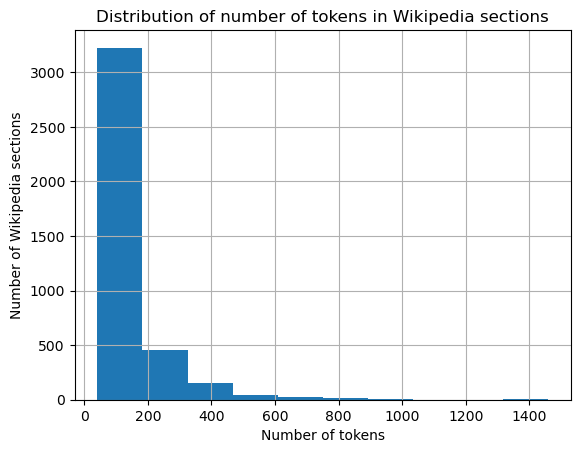

In [52]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('olympics_sections.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()

We can see that the majority of section are fairly short (less than 500 tokens).